# Toxic Comment Classification

![SageMaker](https://img.shields.io/badge/SageMaker-%23FF9900.svg?style=for-the-badge&logo=amazon-aws&logoColor=white)

This notebook is a part of [ToChiquinho](https://dougtrajano.github.io/ToChiquinho/) project, which trains a model to classify comments as toxic or not toxic. We used the [OLID-BR](https://dougtrajano.github.io/olid-br/) dataset as the training data.

The model is trained using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).

- [Setup](#Setup)
- [Prepare the data](#Prepare-the-data)
  - [Uploading the data to S3](#Uploading-the-data-to-S3)
- [Training process](#Training-process)
  - [Define the estimator](#Define-the-estimator)
  - [Hyperparameter tuning](#Hyperparameter-tuning)
  - [Training best model](#Training-best-model)
- [Documentation](#Documentation)

## Setup

In this section, we will import the necessary libraries and set up the environment.

In [1]:
from dotenv import load_dotenv
load_dotenv("../.env")

True

In [2]:
import os
from ml.arguments import NotebookArguments
from ml.utils import remove_checkpoints

params = NotebookArguments(
    num_train_epochs=30,
    early_stopping_patience=5,
    mlflow_experiment_name="toxic-comment-classification",
    mlflow_tags={
        "project": "ToChiquinho",
        "dataset": "OLID-BR",
        "model_type": "bert",
        "problem_type": "binary_classification"
    },
    sagemaker_execution_role_arn=os.environ.get("SAGEMAKER_EXECUTION_ROLE_ARN"),
    sagemaker_tuning_job_name = "pytorch-training-230202-1408",
    aws_profile_name=os.environ.get("AWS_PROFILE")
)

params

NotebookArguments(num_train_epochs=30, early_stopping_patience=5, batch_size=8, validation_split=0.2, seed=1993, mlflow_experiment_name='toxic-comment-classification', mlflow_tags='{"project": "ToChiquinho", "dataset": "OLID-BR", "model_type": "bert", "problem_type": "binary_classification"}', sagemaker_image_uri='215993976552.dkr.ecr.us-east-1.amazonaws.com/sagemaker-transformers:1.12.0-gpu-py38')

In [3]:
import boto3
import sagemaker

sagemaker_session = sagemaker.Session(
    boto_session=boto3.Session(profile_name=params.aws_profile_name)
)

bucket_name = sagemaker_session.default_bucket()
prefix = f"ToChiquinho/{params.mlflow_experiment_name}"

if params.sagemaker_execution_role_arn is None:
    params.sagemaker_execution_role_arn = sagemaker.get_execution_role(sagemaker_session)

## Prepare the data

In this section, we will prepare the data to be used in the training process.

For this task, we will use OLID-BR dataset from [HuggingFace Datasets](https://huggingface.co/datasets/olidbr) and non-offensive comments from other Brazilian Portuguese datasets.

In [4]:
from datasets import load_dataset

dataset = load_dataset("dougtrajano/olid-br")
dataset

Using custom data configuration dougtrajano--olid-br-f83aad8215e23434
Found cached dataset parquet (C:/Users/trajano/.cache/huggingface/datasets/dougtrajano___parquet/dougtrajano--olid-br-f83aad8215e23434/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['id', 'text', 'is_offensive', 'is_targeted', 'targeted_type', 'toxic_spans', 'health', 'ideology', 'insult', 'lgbtqphobia', 'other_lifestyle', 'physical_aspects', 'profanity_obscene', 'racism', 'religious_intolerance', 'sexism', 'xenophobia'],
        num_rows: 1589
    })
    train: Dataset({
        features: ['id', 'text', 'is_offensive', 'is_targeted', 'targeted_type', 'toxic_spans', 'health', 'ideology', 'insult', 'lgbtqphobia', 'other_lifestyle', 'physical_aspects', 'profanity_obscene', 'racism', 'religious_intolerance', 'sexism', 'xenophobia'],
        num_rows: 4765
    })
})

In [33]:
import json
import boto3

session = boto3.Session(profile_name=params.aws_profile_name)
s3 = session.resource("s3")
bucket = s3.Bucket("toxicity-detection-dev-bucket")
obj = bucket.Object("processed/related_datasets/is_offensive.json")
related_datasets = json.loads(obj.get()["Body"].read().decode("utf-8"))

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [64]:
from sklearn.model_selection import train_test_split

non_offensive_comments = [
    i for i in related_datasets if i["is_offensive"] == "NOT"
]

X = [i["text"] for i in non_offensive_comments]
y = [i["is_offensive"] for i in non_offensive_comments]

# Reduce dataset size
X, _, y, _ = train_test_split(
    X, y,
    test_size=0.6,
    random_state=params.seed,
    stratify=y
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=params.seed,
    stratify=y
)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 6493
Test size: 1624


In [65]:
import datasets

X_train = X_train + dataset["train"]["text"]
y_train = y_train + dataset["train"]["is_offensive"]
X_test = X_test + dataset["test"]["text"]
y_test = y_test + dataset["test"]["is_offensive"]

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 11258
Test size: 3213


In [66]:
dataset = datasets.DatasetDict(
    {
        "train": datasets.Dataset.from_dict(
            {
                "text": X_train,
                "is_offensive": y_train
            }
        ),
        "test": datasets.Dataset.from_dict(
            {
                "text": X_test,
                "is_offensive": y_test
            }
        )
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'is_offensive'],
        num_rows: 11258
    })
    test: Dataset({
        features: ['text', 'is_offensive'],
        num_rows: 3213
    })
})

In [67]:
import ast
import datasets
from typing import Union

def prepare_dataset(
    dataset: Union[datasets.Dataset, datasets.DatasetDict],
    test_size: float = 0.2,
    seed: int = 42
) -> Union[datasets.Dataset, datasets.DatasetDict]:    
    # Filter only "text" and "is_offensive" columns
    dataset = dataset.remove_columns(
        [
            col for col in dataset["train"].column_names if col not in [
                "text",
                "is_offensive"
            ]
        ]
    )

    dataset = dataset.rename_column("is_offensive", "label")

    # Replace "OFF": 1 and "NOT": 0
    def replace_labels(example):
        if example["label"] == "OFF":
            example["label"] = 1
        elif example["label"] == "NOT":
            example["label"] = 0
        else:
            raise ValueError(f"Invalid label: {example['label']}")
        return example

    dataset = dataset.map(replace_labels)

    train_dataset = dataset["train"].train_test_split(
        test_size=test_size,
        shuffle=True,
        seed=seed
    )

    dataset["train"] = train_dataset["train"]
    dataset["validation"] = train_dataset["test"]

    return dataset


dataset = prepare_dataset(
    dataset,
    test_size=params.validation_split,
    seed=params.seed
)

dataset

  0%|          | 0/11258 [00:00<?, ?ex/s]

  0%|          | 0/3213 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9006
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3213
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2252
    })
})

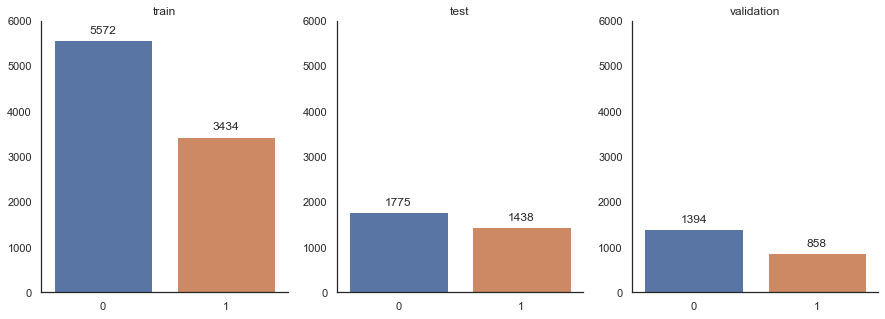

In [15]:
# Plot the distribution of the labels in each dataset split
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    style="white",
    rc={
        "axes.spines.right": False,
        "axes.spines.top": False
    }
)

def plot_label_distribution(dataset: datasets.DatasetDict):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    for i, split in enumerate(dataset):
        sns.countplot(
            x="label",
            data=dataset[split].to_pandas(),
            ax=ax[i]
        )

        ax[i].set_ylim(0, 6000)

        ax[i].set_title(split)
        ax[i].set_ylabel("")
        ax[i].set_xlabel("")

        # Add annotations
        for p in ax[i].patches:
            ax[i].annotate(
                format(p.get_height(), ".0f"),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center",
                va="center",
                xytext=(0, 10),
                textcoords="offset points"
            )

    plt.show()

plot_label_distribution(dataset)

In [71]:
dataset.save_to_disk("data")

Flattening the indices:   0%|          | 0/10 [00:00<?, ?ba/s]

Saving the dataset (0/1 shards):   0%|          | 0/9006 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3213 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/3 [00:00<?, ?ba/s]

Saving the dataset (0/1 shards):   0%|          | 0/2252 [00:00<?, ? examples/s]

### Uploading the data to S3

We are going to use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location.

The return value inputs identifies the location -- we will use later when we start the training job.

In [4]:
# inputs = sagemaker_session.upload_data(
#     path="data",
#     bucket=bucket_name,
#     key_prefix=f"{prefix}/data"
# )

inputs = "s3://sagemaker-us-east-1-215993976552/ToChiquinho/toxic-comment-classification/data"

print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-215993976552/ToChiquinho/toxic-comment-classification/data


In [ ]:
import shutil
shutil.rmtree("data")

## Training session

In this section, we will run the training process.

To use Amazon SageMaker to run Docker containers, we need to provide a Python script for the container to run. In our case, all the code is in the `ml` folder, including the `train.py` script.

We will start doing a hyperparameter tuning process to find the best hyperparameters for our model.

Then, we will train the model using the best hyperparameters found.

In [5]:
import os
import mlflow

mlflow.start_run()

print(f"MLFlow run ID: {mlflow.active_run().info.run_id}")

MLFlow run ID: 227c8f6d9b144862a866d6de38d206dc


### Define the estimator

We will use the `sagemaker.huggingface.HuggingFace` class to define our estimator.

In [14]:
import logging
from sagemaker.huggingface import HuggingFace

checkpoint_s3_uri = f"s3://{bucket_name}/{prefix}/checkpoints"

# instance_type = "ml.g4dn.xlarge" # 4 vCPUs, 16 GB RAM, 1 x NVIDIA T4 16GB GPU - $ 0.736 per hour
# instance_type = "ml.g4dn.2xlarge" # 8 vCPUs, 32 GB RAM, 1 x NVIDIA T4 16GB GPU - $ 0.94 per hour
instance_type = "ml.g5.xlarge" # 4 vCPUs, 16 GB RAM, 1 x NVIDIA A10G 24GB GPU - $ 1.408 per hour
# instance_type = "ml.g5.2xlarge" # 8 vCPUs, 32 GB RAM, 1 x NVIDIA A10G 24GB GPU - $ 1.515 per hour
# instance_type = "ml.g5.4xlarge" # 16 vCPUs, 64 GB RAM, 2 x NVIDIA A10G 24GB GPU - $ 2.03 per hour
# instance_type = "ml.g5.8xlarge" # 32 vCPUs, 128 GB RAM, 4 x NVIDIA A10G 24GB GPU - $ 3.06 per hour

estimator = HuggingFace(
    entry_point="train.py",
    source_dir="ml",
    base_job_name=params.mlflow_experiment_name,
    container_log_level=logging.DEBUG,
    role=params.sagemaker_execution_role_arn,
    sagemaker_session=sagemaker_session,
    py_version="py38",
    pytorch_version="1.10.2",
    transformers_version="4.17.0",
    instance_count=1,
    instance_type=instance_type,
    use_spot_instances=True,
    max_wait=10800,
    max_run=10800,
    checkpoint_s3_uri=checkpoint_s3_uri,
    checkpoint_local_path="/opt/ml/checkpoints",
    environment={
        "MLFLOW_TRACKING_URI": params.mlflow_tracking_uri,
        "MLFLOW_EXPERIMENT_NAME": params.mlflow_experiment_name,
        "MLFLOW_TRACKING_USERNAME": params.mlflow_tracking_username,
        "MLFLOW_TRACKING_PASSWORD": params.mlflow_tracking_password,
        "MLFLOW_TAGS": params.mlflow_tags,
        "MLFLOW_RUN_ID": mlflow.active_run().info.run_id,
        "MLFLOW_FLATTEN_PARAMS": "True"
    },
    hyperparameters={
        ## If you want to test the code, uncomment the following lines to use smaller datasets
        # "max_train_samples": 100,
        # "max_val_samples": 100,
        # "max_test_samples": 100,
        "num_train_epochs": params.num_train_epochs,
        "early_stopping_patience": params.early_stopping_patience,
        "eval_dataset": "validation",
        "batch_size": params.batch_size,
        "seed": params.seed
    }
)

In [7]:
mlflow.log_params(
    {
        "instance_type": estimator.instance_type,
        "instance_count": estimator.instance_count,
        "early_stopping_patience": params.early_stopping_patience
    }
)

To test our training job before hyperparameter tuning, we will run it with a small number of samples.

In [75]:
estimator.fit(inputs, wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.estimator:SMDebug Does Not Currently Support                         Distributed Training Jobs With Checkpointing Enabled
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-02-02-16-12-51-878


### Hyperparameter Tuning

We will use the `sagemaker.tuner.HyperparameterTuner` class to run a hyperparameter tuning process.

We use MLflow to track the training process, so we can analyze the results through the MLflow UI.

In [12]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

estimator._hyperparameters.pop("max_train_samples", None)
estimator._hyperparameters.pop("max_val_samples", None)
estimator._hyperparameters.pop("max_test_samples", None)

tuner = HyperparameterTuner(
    estimator,
    max_jobs=18,
    max_parallel_jobs=3,
    objective_type="Maximize",
    objective_metric_name="eval_f1",
    metric_definitions=[
        {
            "Name": "eval_f1",
            "Regex": "eval_f1_weighted: ([0-9\\.]+)"
        }
    ],
    hyperparameter_ranges={
        "learning_rate": ContinuousParameter(1e-5, 1e-3),
        "weight_decay": ContinuousParameter(0.0, 0.1),
        "adam_beta1": ContinuousParameter(0.8, 0.999),
        "adam_beta2": ContinuousParameter(0.8, 0.999),
        "adam_epsilon": ContinuousParameter(1e-8, 1e-6),
        "label_smoothing_factor": ContinuousParameter(0.0, 0.1),
        "optim": CategoricalParameter(
            [
                "adamw_hf",
                "adamw_torch",
                "adamw_apex_fused",
                "adafactor"
            ]
        )
    }
)

In [13]:
tuner.fit(inputs, wait=False)

params.sagemaker_tuning_job_name = tuner.latest_tuning_job.name

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [8]:
print(f"SageMaker tuning job name: {params.sagemaker_tuning_job_name}")

SageMaker tuning job name: pytorch-training-230202-1408


In [9]:
import pandas as pd

tuner_metrics: pd.DataFrame = sagemaker.HyperparameterTuningJobAnalytics(
    hyperparameter_tuning_job_name=params.sagemaker_tuning_job_name,
    sagemaker_session=sagemaker_session
).dataframe()

tuner_metrics["optim"] = tuner_metrics["optim"].apply(lambda x: x.strip('"'))

tuner_metrics.sort_values("FinalObjectiveValue", ascending=False, inplace=True)
tuner_metrics[["TrainingJobName", "FinalObjectiveValue", "TrainingJobStatus"]]

,TrainingJobName,FinalObjectiveValue,TrainingJobStatus
17,pytorch-training-230202-1408-001-3a7ba5a5,0.868192,Completed
8,pytorch-training-230202-1408-010-fa54f873,0.865947,Completed
7,pytorch-training-230202-1408-011-51c0a2c0,0.865674,Completed
10,pytorch-training-230202-1408-008-38cd8920,0.864526,Completed
3,pytorch-training-230202-1408-015-edf8d39c,0.863600,Completed
0,pytorch-training-230202-1408-018-9deed799,0.861810,Completed
6,pytorch-training-230202-1408-012-566ef2d0,0.860839,Completed
4,pytorch-training-230202-1408-014-ed39b6e7,0.860671,Completed
9,pytorch-training-230202-1408-009-140c0893,0.860427,Completed
13,pytorch-training-230202-1408-005-777c7510,0.859007,Completed


In [10]:
best_job = tuner_metrics.iloc[0].copy()
best_job.to_dict()

{'adam_beta1': 0.8445637934160373,
 'adam_beta2': 0.8338816842140165,
 'adam_epsilon': 2.527092625455385e-08,
 'label_smoothing_factor': 0.07158711257743958,
 'learning_rate': 3.255788747459486e-05,
 'optim': 'adamw_hf',
 'weight_decay': 0.031031065174245122,
 'TrainingJobName': 'pytorch-training-230202-1408-001-3a7ba5a5',
 'TrainingJobStatus': 'Completed',
 'FinalObjectiveValue': 0.8681923151016235,
 'TrainingStartTime': Timestamp('2023-02-02 14:09:25-0300', tz='tzlocal()'),
 'TrainingEndTime': Timestamp('2023-02-02 14:37:19-0300', tz='tzlocal()'),
 'TrainingElapsedTimeSeconds': 1674.0}

### Training best model

We will train the model using the best hyperparameters found.

We will concatenate the training and validation datasets to train the model with more data and evaluate it using the test dataset.

In [15]:
estimator.environment = {
    "MLFLOW_TRACKING_URI": params.mlflow_tracking_uri,
    "MLFLOW_EXPERIMENT_NAME": params.mlflow_experiment_name,
    "MLFLOW_TRACKING_USERNAME": params.mlflow_tracking_username,
    "MLFLOW_TRACKING_PASSWORD": params.mlflow_tracking_password,
    "MLFLOW_TAGS": params.mlflow_tags,
    "MLFLOW_RUN_ID": mlflow.active_run().info.run_id,
    "MLFLOW_FLATTEN_PARAMS": "True",
    "HF_MLFLOW_LOG_ARTIFACTS": "True",
    "HUGGINGFACE_HUB_TOKEN": params.huggingface_hub_token
}

estimator._hyperparameters = {
    "push_to_hub": "True",
    "hub_model_id": f"dougtrajano/{params.mlflow_experiment_name}",
    "num_train_epochs": params.num_train_epochs,
    "early_stopping_patience": params.early_stopping_patience,
    "batch_size": params.batch_size,
    "seed": params.seed,
    "concat_validation_set": "True",
    "eval_dataset": "test",
    "adam_beta1": best_job["adam_beta1"],
    "adam_beta2": best_job["adam_beta2"],
    "adam_epsilon": best_job["adam_epsilon"],
    "learning_rate": best_job["learning_rate"],
    "weight_decay": best_job["weight_decay"],
    "label_smoothing_factor": best_job["label_smoothing_factor"],
    "optim": best_job["optim"]
}

estimator.fit(inputs, wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: toxic-comment-classification-2023-02-26-22-07-06-968


In [13]:
remove_checkpoints(
    bucket_name=bucket_name,
    checkpoint_prefix=f"{prefix}/checkpoints",
    aws_profile_name=params.aws_profile_name
)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Deleted 42 checkpoints from sagemaker-us-east-1-215993976552/ToChiquinho/toxic-comment-classification/checkpoints.


In [ ]:
mlflow.end_run()

## Documentation

- [Estimators — sagemaker documentation](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)
- [HyperparameterTuner — sagemaker documentation](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html)
- [Configure and Launch a Hyperparameter Tuning Job - Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-ex-tuning-job.html)
- [Managed Spot Training in Amazon SageMaker - Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html)